<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

# ResNet Architecture


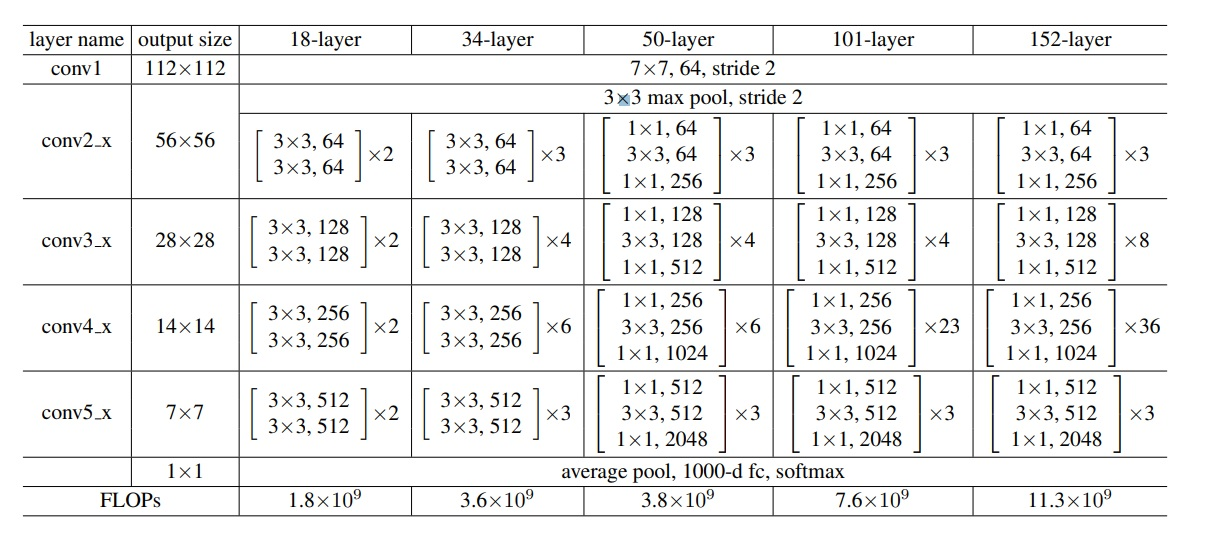

# ResNet-50 Architecture

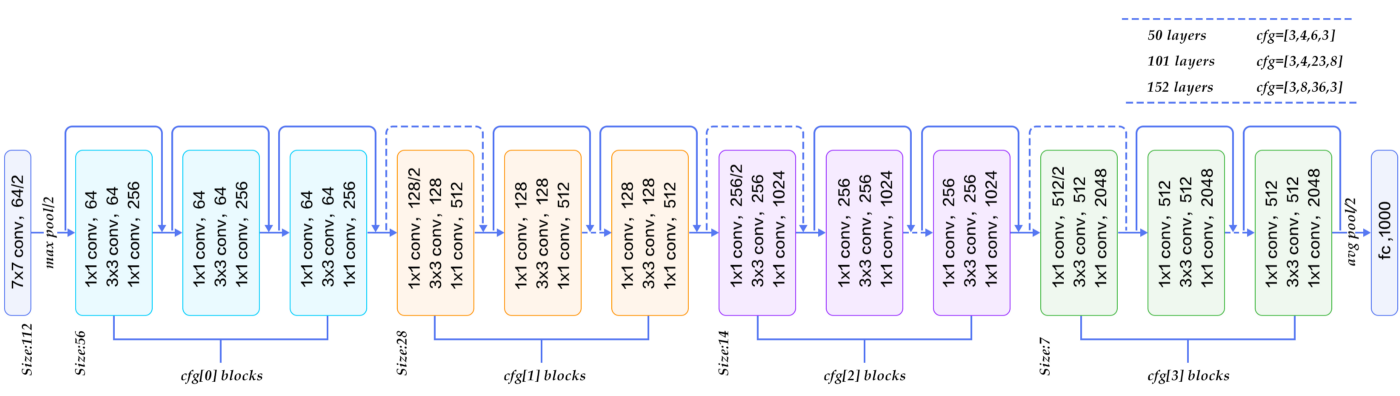

# The identity block
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say ) has the same dimension as the output activation (say ). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

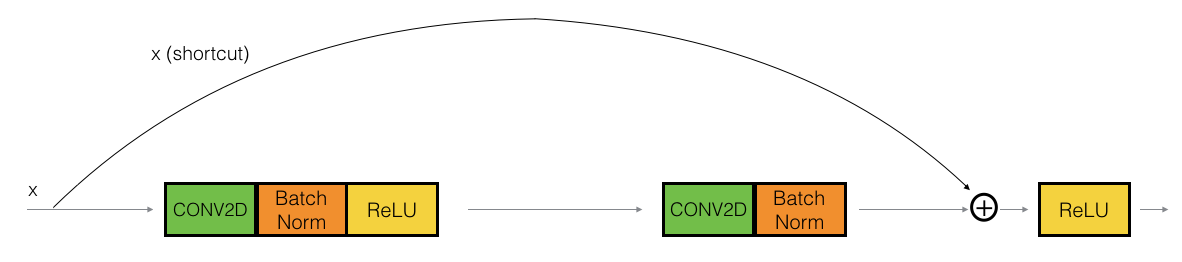

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this:

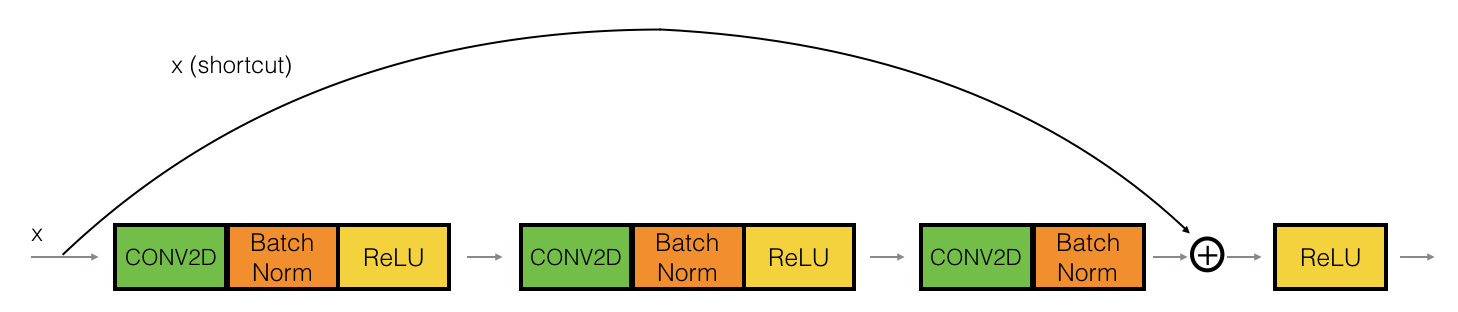



**First component of main path:**

The first CONV2D has  filters of shape (1,1) and a stride of (1,1). Its padding is "valid" 

The first BatchNorm is normalizing the 'channels' axis.

Then apply the ReLU activation function. 


**Second component of main path:**

The second CONV2D has  filters of shape  and a stride of (1,1). Its padding is "same" 

The second BatchNorm is normalizing the 'channels' axis.

Then apply the ReLU activation function.


**Third component of main path:**

The third CONV2D has  filters of shape (1,1) and a stride of (1,1). Its padding is "valid" 

The third BatchNorm is normalizing the 'channels' axis.

Note that there is no ReLU activation function in this component.

**Final step:**

The X_shortcut and the output from the 3rd layer X are added together.
Then apply the ReLU activation function.

In [2]:
#identity block doesn't change input sizes and the number of channels.
class Identity_block(nn.Module):
  def __init__(self,filters,in_channels):
    super().__init__()
    F1,F2 = filters

    # First component of main path
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=F1,kernel_size=1) # default: stride=1, padding=0
    self.batch1 = nn.BatchNorm2d(F1)
    self.relu = nn.ReLU()

    # Second component of main path (≈3 lines)
    self.conv2 = nn.Conv2d(in_channels=F1, out_channels=F2,kernel_size=3,stride=1,padding=1) # OR padding='same' when stride=1
    self.batch2 = nn.BatchNorm2d(F2)

    # Third component of main path (≈2 lines)
    self.conv3 = nn.Conv2d(in_channels=F2, out_channels=in_channels,kernel_size=1) 
    self.batch3 = nn.BatchNorm2d(in_channels)

  def forward(self,x):
    x_shortcut = x

    x = self.conv1(x)
    x = self.batch1(x)
    x = self.relu(x)
        
    x = self.conv2(x)
    x = self.batch2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.batch3(x)

    x += x_shortcut 
    x = self.relu(x)

    return x

# The convolutional block
The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

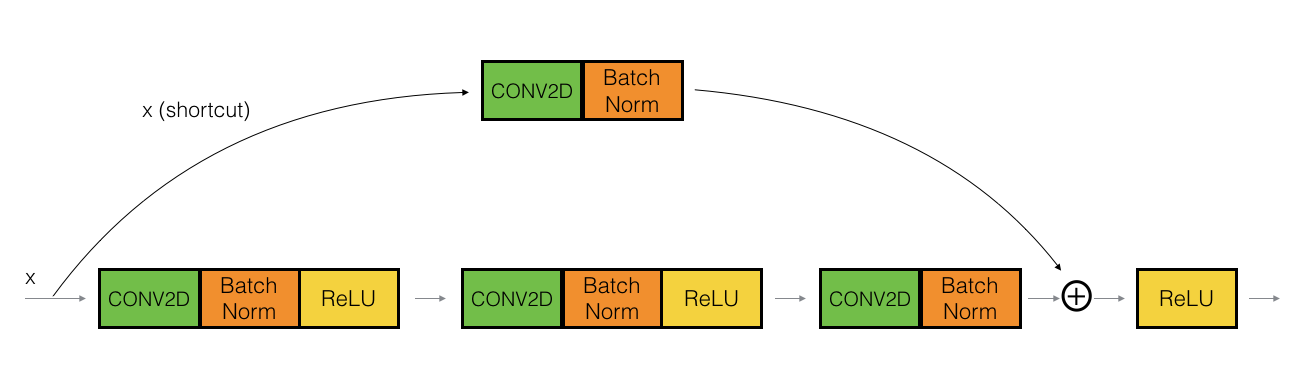

The CONV2D layer in the shortcut path is used to resize the input  to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. 

For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.

The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

**First component of main path:**

The first CONV2D has  filters of shape (1,1) and a stride of (s,s). Its padding is "valid"

The first BatchNorm is normalizing the 'channels' axis.

Then apply the ReLU activation function.


**Second component of main path:** 

The second CONV2D has  filters of shape (f,f) and a stride of (1,1). Its padding is "same" 

The second BatchNorm is normalizing the 'channels' axis. 

Then apply the ReLU activation function.


**Third component of main path:**

The third CONV2D has  filters of shape (1,1) and a stride of (1,1). Its padding is "valid"

The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component.


**Shortcut path:**

The CONV2D has  filters of shape (1,1) and a stride of (s,s). Its padding is "valid" 
The BatchNorm is normalizing the 'channels' axis.


**Final step:**

The shortcut and the main path values are added together.
Then apply the ReLU activation function. 

In [3]:
class Convolutional_block(nn.Module):
  def __init__(self, filters, s, in_channels):
    super().__init__()
    F1,F2,F3 = filters

    # First component of main path
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=F1,kernel_size=1,stride=s) #reduce the activation dimensions's by half
    self.batch1 = nn.BatchNorm2d(F1)
    self.relu = nn.ReLU()

    # Second component of main path (≈3 lines)
    self.conv2 = nn.Conv2d(in_channels=F1, out_channels=F2,kernel_size=3,stride=1,padding=1) # OR padding='same' when stride=1
    self.batch2 = nn.BatchNorm2d(F2)

    # Third component of main path (≈2 lines)
    self.conv3 = nn.Conv2d(in_channels=F2, out_channels=F3,kernel_size=1) 
    self.batch3 = nn.BatchNorm2d(F3)    

    #Shortcut path
    self.shortcut_conv = nn.Conv2d(in_channels=in_channels, out_channels=F3,kernel_size=1,stride=s)
    self.shortcut_batch = nn.BatchNorm2d(F3)

  def forward(self,x):
    x_shortcut = x

    x = self.conv1(x)
    x = self.batch1(x)
    x = self.relu(x)
      
    x = self.conv2(x)
    x = self.batch2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.batch3(x)

    x_shortcut = self.shortcut_conv(x_shortcut)
    x_shortcut = self.shortcut_batch(x_shortcut)

    x += x_shortcut

    return x




# Building your first ResNet model (50 layers)
You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

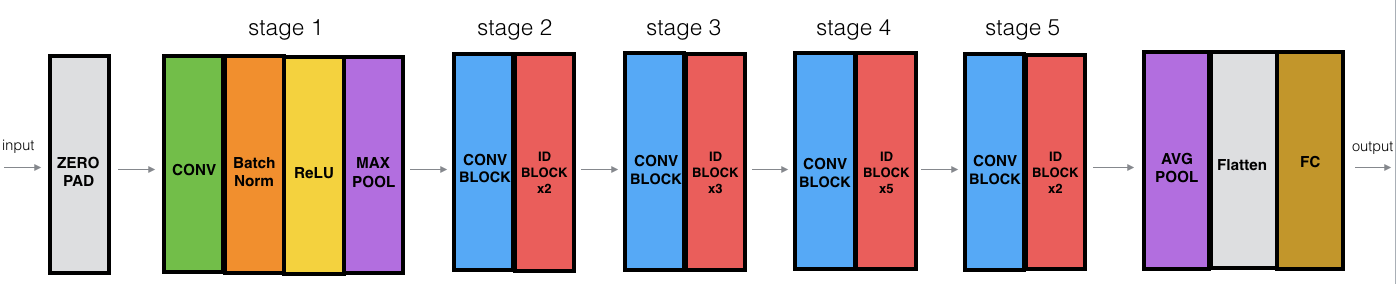



Zero-padding pads the input with a pad of (3,3)

**Stage 1:**

The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".

BatchNorm is applied to the 'channels' axis of the input.

MaxPooling uses a (3,3) window and a (2,2) stride.

**Stage 2:**

The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, "s" is 1 

The 2 identity blocks use three sets of filters of size [64,64,256], "f" is 3 

**Stage 3:**

The convolutional block uses three sets of filters of size [128,128,512], "f" is 3, "s" is 2 .

The 3 identity blocks use three sets of filters of size [128,128,512], "f" is 3 

**Stage 4:**

The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3, "s" is 2 

The 5 identity blocks use three sets of filters of size [256, 256, 1024], "f" is 3 

**Stage 5:**

The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3, "s" is 2 

The 2 identity blocks use three sets of filters of size [512, 512, 2048], "f" is 3 

The 2D Average Pooling uses a window of shape (2,2) .

The 'flatten' layer doesn't have any hyperparameters .

The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [4]:
class ResNet50(nn.Module):
  def __init__(self, Identity_block, Convolutional_block, num_classes = 6):
    super().__init__()

    self.stage1 = nn.Sequential(nn.ConstantPad2d(3,0),  # (padding, value)
                                nn.Conv2d(3,64,kernel_size=7,stride=2),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=3,stride=2),
                                ) 
    
    self.stage2 = nn.Sequential(Convolutional_block([64,64,256],s=1,in_channels=64),
                                Identity_block([64,64],in_channels=256),
                                Identity_block([64,64],in_channels=256),
                                )
    
    self.stage3 = nn.Sequential(Convolutional_block([128,128,512],s=2,in_channels=256),
                                Identity_block([128,128],in_channels=512),
                                Identity_block([128,128],in_channels=512),
                                Identity_block([128,128],in_channels=512),
                                )
    
    self.stage4 = nn.Sequential(Convolutional_block([256,256,1024],s=2,in_channels=512),
                                Identity_block([256,256],in_channels=1024),
                                Identity_block([256,256],in_channels=1024),
                                Identity_block([256,256],in_channels=1024),
                                Identity_block([256,256],in_channels=1024),
                                Identity_block([256,256],in_channels=1024),
                                )

    self.stage5 = nn.Sequential(Convolutional_block([512,512,2048],s=2,in_channels=1024),
                                Identity_block([512,512],in_channels=2048),
                                Identity_block([512,512],in_channels=2048),                                
                                )
    
    self.avg_pool = nn.AvgPool2d(2)
    self.linear = nn.Linear(2048, num_classes)

  def forward(self,x):
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    x = self.avg_pool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.linear(x)

    return x


In [5]:
model = ResNet50(Identity_block, Convolutional_block, num_classes = 6)

In [6]:
a = torch.randn((4,3,64,64))
print(model(a).shape)

torch.Size([4, 6])


In [7]:
!wget 'https://github.com/furkanu/deeplearning.ai-pytorch/raw/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/train_signs.h5'

--2022-08-24 15:36:07--  https://github.com/furkanu/deeplearning.ai-pytorch/raw/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/train_signs.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/train_signs.h5 [following]
--2022-08-24 15:36:07--  https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/train_signs.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [8]:
!wget 'https://github.com/furkanu/deeplearning.ai-pytorch/raw/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/test_signs.h5'

--2022-08-24 15:36:20--  https://github.com/furkanu/deeplearning.ai-pytorch/raw/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/test_signs.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/test_signs.h5 [following]
--2022-08-24 15:36:20--  https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/datasets/test_signs.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14

In [9]:
!wget 'https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/resnets_utils.py'

--2022-08-24 15:36:22--  https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/4-%20Convolutional%20Neural%20Networks/Week%202/ResNets%20(Done)/resnets_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 944 [text/plain]
Saving to: ‘resnets_utils.py’

resnets_utils.py    100%[===================>]     944  --.-KB/s    in 0s      

2022-08-24 15:36:22 (54.8 MB/s) - ‘resnets_utils.py’ saved [944/944]



In [44]:
from resnets_utils import *
import numpy as np
import h5py
from torch.utils.data import Dataset , DataLoader

X_train_orig, Y_train, X_test_orig, Y_test, classes = load_dataset()

In [45]:
print(X_train_orig.shape, Y_train.shape, X_test_orig.shape, Y_test.shape, classes.shape)

(1080, 64, 64, 3) (1, 1080) (120, 64, 64, 3) (1, 120) (6,)


In [46]:
X_train_orig = np.transpose(X_train_orig,[0,3,1,2])
X_test_orig = np.transpose(X_test_orig,[0,3,1,2])

Y_train = np.transpose(Y_train,[1,0])
Y_test = np.transpose(Y_test,[1,0])

print(X_train_orig.shape, Y_train.shape, X_test_orig.shape, Y_test.shape)

(1080, 3, 64, 64) (1080, 1) (120, 3, 64, 64) (120, 1)


In [47]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
Y_train = torch.from_numpy(Y_train.astype(np.float32))
Y_test = torch.from_numpy(Y_test.astype(np.float32))

In [49]:
class Dataload(Dataset):
  def __init__(self,train=True):
    self.X_train = X_train
    self.Y_train = Y_train
    self.X_test = X_test
    self.Y_test = Y_test
    self.train = train

    self.train_samples = Y_train.shape[0]
    self.test_samples = Y_test.shape[0]

  def __getitem__(self, index):
    if self.train :
      return self.X_train[index],self.Y_train[index]
    else :
      return self.X_test[index],self.Y_test[index]

  def __len__(self):
     if self.train :
      return self.train_samples
     else :
      return self.test_samples


In [55]:
train_loader = torch.utils.data.DataLoader(Dataload(train=True),batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(Dataload(train=False),batch_size=32)

In [56]:
a,b= next(iter(train_loader))
print(a.shape,b.shape)

torch.Size([32, 3, 64, 64]) torch.Size([32, 1])


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50(Identity_block, Convolutional_block, num_classes = 6).to(device)

In [59]:
num_epochs = 1
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),learning_rate)

In [61]:
running_correct = 0
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}/{num_epochs} ')
  print('_ _ ' * 10)
  running_correct = 0
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1) 
    running_correct += (labels==predicted).sum().item()

    if (i+1) % 100 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{n_total_steps} , Loss : {loss.item():.4f}  ')

  accuracy = (float(running_correct)/float(n_total_steps))
  print(f'Epoch {epoch+1}/{num_epochs} , accuracy : {loss.item():.4f}  ')



Epoch 1/1 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


RuntimeError: ignored